In [14]:
import torch
import numpy as np
from glob import glob
import pickle
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [16]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import random
from torch import nn, optim

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

In [19]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):

    
    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[:int(n * 0.1)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[:int(n * 0.1)]
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[int(n * 0.1):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.1):]
    
    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)
    
    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

# intialize a dataset
city = 'austin' 
split = 'train'
inputs, outputs = get_city_trajectories(city='austin', split='train')

FileNotFoundError: [Errno 2] No such file or directory: './train/austin_inputs'

In [6]:
inputs.shape, outputs.shape

NameError: name 'inputs' is not defined

# Data Normalization and Standardization For Time Series

## Why do we need to normalize time series?
#### 1). Large input values can result in a model that learns large weight values. 
#### 2). Large target values result in large error gradient values causing weight values to change dramatically, making the learning process unstable.

In [6]:
global_mean = np.mean(inputs, axis = (0,1), keepdims = True)
global_std = np.std(np.sqrt(inputs[:, :, 0]**2 + inputs[:, :, 0]**2))
standard_inputs = (inputs - global_mean)/global_std
standard_targets = (outputs - global_mean)/global_std

(array([  6270.,  19766., 346886., 662378., 628304., 465532., 248990.,
        149815.,  51938.,   2581.]),
 array([-2.13738842, -1.67110405, -1.20481967, -0.7385353 , -0.27225093,
         0.19403344,  0.66031781,  1.12660219,  1.59288656,  2.05917093,
         2.5254553 ]),
 <a list of 10 Patch objects>)

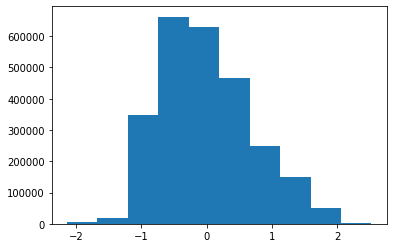

In [8]:
plt.hist(standard_targets[:,:,1].reshape(-1))

In [ ]:
# predictions = model(standard_inputs)
# loss_fun(predictions, standard_targets)
# inverse_preds = predictions*global_std + global_mean

In [7]:
global_min = np.min(inputs, axis = (0,1), keepdims = True)
global_max = np.max(inputs, axis = (0,1), keepdims = True)
normal_inputs = (inputs - global_min)/(global_max - global_min)
normal_targets = (outputs - global_min)/(global_max - global_min)

In [9]:
traj_min = np.min(inputs, axis = (1), keepdims = True)
traj_max = np.max(inputs, axis = (1), keepdims = True)
normal_inputs = (inputs - traj_min)/(traj_max - traj_min)
normal_targets = (outputs - traj_min)/(traj_max - traj_min)

# Time Series Forecasting Models

In [8]:
one_batch = torch.from_numpy(standard_inputs[:32]).float()

## 1. Autoregressive Regression

In [10]:
# Linear Regression
class LR(torch.nn.Module):
    def __init__(self, input_dim, out_dim):
        super(LR, self).__init__()
        """
        the __init__() method that defines the layers and other components
        """ 
        self.model = nn.Linear(input_dim, out_dim) # input_dim = input_length*2
        
    def forward(self, x, output_steps): 
        """
        the forward function is where computatioin gets done
        """
        x = x.reshape(x.shape[0], -1)
        
        outputs = []
        for i in range(output_steps):
            out = self.model(x)    
            outputs.append(out)
            x = torch.cat([x[:,2:],  out], dim = 1)
            
        outputs = torch.cat(outputs, dim = 1)
        return outputs.reshape(outputs.shape[0], output_steps, 2)
    
model = LR(input_dim = 50 * 2, out_dim = 2)

In [11]:
out = model(one_batch, 60)

## 2. MLP

In [13]:
class MLP(nn.Module):
    def __init__(self, input_dim, out_dim, hidden_dim):
        super(MLP, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(), 
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(), 
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(), 
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(), 
            nn.Linear(hidden_dim, out_dim) #out_dim = 60*2
        )
        
    def forward(self, x, output_steps): 
        x = x.reshape(x.shape[0], -1)
        outputs = []
        
        for i in range(output_steps):
            out = self.model(x)    
            outputs.append(out)
            x = torch.cat([x[:,2:],  out], dim = 1)
            
        outputs = torch.cat(outputs, dim = 1)
        return outputs.reshape(outputs.shape[0], output_steps, 2)
     # def forward(self, x, output_steps): 
     #    x = x.reshape(x.shape[0], -1)
     #    outputs = self.model(x)
     #    return outputs.reshape(outputs.shape[0], output_steps, 2)


In [16]:
model = MLP(input_dim = 50 * 2, out_dim = 2, hidden_dim = 128)

In [17]:
out = model(one_batch, 60)

## 3. Temporal CNN

In [19]:
class TCN(nn.Module):
    def __init__(self, input_channels, out_channels, hidden_dim, kernel_size):
        super(TCN, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv1d(input_channels, hidden_dim, kernel_size = kernel_size, padding = (kernel_size - 1)//2),
            nn.LeakyReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size = kernel_size, padding = (kernel_size - 1)//2),
            nn.LeakyReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size = kernel_size, padding = (kernel_size - 1)//2),
            nn.LeakyReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size = kernel_size, padding = (kernel_size - 1)//2),
            nn.LeakyReLU(),
            nn.Conv1d(hidden_dim, out_channels, kernel_size = kernel_size, padding = (kernel_size - 1)//2)
        ) 
        
      
    def forward(self, x): 
        
        x = x.transpose(1,2)
        
        outputs = self.model(x)
        
        return outputs.transpose(1,2)

In [20]:
model = TCN(input_channels = 2, out_channels = 2, hidden_dim = 16, kernel_size = 3)

In [21]:
out = model(one_batch)

## 4. Seq2Seq with Attention

In [188]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_rate):
        
        super(Encoder, self).__init__()

        self.lstm = nn.LSTM(input_size = input_dim, 
                            hidden_size = hidden_dim, 
                            num_layers= num_layers, 
                            dropout = dropout_rate, 
                            batch_first = True)
        
        
    def forward(self, source):
        
        # hidden = (h, c)
        # h, c: num_layers x bz x  hid_dim
        # outputs: bz x input_length x hid_dim
        outputs, hidden = self.lstm(source)
        
        return outputs, hidden
    
class AttnDecoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, num_layers, dropout_rate):

        super(AttnDecoder, self).__init__()

        # Learn the attention scores
        self.attn = nn.Linear(hidden_dim + output_dim, 50)
        
        # Learn the final input to the decoder 
        self.attn_combine = nn.Linear(hidden_dim + output_dim, hidden_dim)
        
        # Decoder LSTM
        self.lstm = nn.LSTM(input_size = hidden_dim, 
                            hidden_size = hidden_dim, 
                            num_layers= num_layers, 
                            dropout = dropout_rate, 
                            batch_first = True)
        
        self.output_layer = nn.Linear(hidden_dim, output_dim)
      
    def forward(self, x, hidden, encoder_outputs):
        
        h = hidden[0]
        h = h.transpose(0,1).reshape(h.shape[1], -1)
        
        # Compute Attention Scores
        attn_weights = F.softmax(self.attn(torch.cat([x, h], 1)), dim =1)
        
        # Calculate weighted sum of encoder hidden states     
        attn_applied = torch.einsum("bl,blh->bh", attn_weights, encoder_outputs)
        
        x = torch.cat((x, attn_applied), dim = 1)
        x = self.attn_combine(x).unsqueeze(1)
        x = F.relu(x)
        
        output, decoder_hidden= self.lstm(x, hidden)  
        prediction = self.output_layer(output.float())
        
        return prediction.squeeze(1), decoder_hidden
    
class Seq2Seq(nn.Module):
    def __init__(self, input_dim = 2, output_dim = 2, hidden_dim = 128, num_layers = 1, dropout_rate = 0):
        
        super(Seq2Seq, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, num_layers, dropout_rate)
        self.decoder = AttnDecoder(output_dim, hidden_dim, num_layers, dropout_rate)

    def forward(self, source, target_length):

        batch_size = source.size(0) 
        input_length = source.size(1) 
        
        encoder_outputs, concat_hidden = self.encoder(source)
        
        # the last encoder hidden state is used as initial hidden state of the decoder
        decoder_hidden = concat_hidden
        # the first input to the decoder is last input position
        decoder_output = source[:,-1]
    
        
        outputs = torch.zeros(batch_size, target_length, 2)
        for t in range(target_length):    
            decoder_output, decoder_hidden = self.decoder(decoder_output, decoder_hidden, encoder_outputs)
            outputs[:,t] = decoder_output   
        return outputs

In [190]:
model = Seq2Seq()

In [191]:
out = model(one_batch, target_length = 60)